In [1]:
import os,sys,string, time
#print (sys.version)
import ROOT
import seaborn as sns
from matplotlib.lines import Line2D
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array

import matplotlib.pyplot as plt


import numpy as np


import uproot
import pandas as pd

from root_pandas import read_root
from platform import python_version

import scipy
from scipy import stats


import uproot3
print ('Success')


Welcome to JupyROOT 6.22/08
Success


TypeError: unsupported operand type(s) for ^: 'float' and 'int'

In [6]:
loc_file = '/uboone/data/users/davidc/searchingfornues/v08_00_00_48/0928/run3/nslice/prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run3_reco2_G_reco2.root'
#data_file = '/uboone/data/users/davidc/searchingfornues/v08_00_00_41/cc0pinp/0617/data_bnb_peleeFilter_uboone_v08_00_00_41_pot_run3_G1_neutrinoselection_filt.root'
EXT_file =  '/uboone/data/users/davidc/searchingfornues/v08_00_00_43/0702/run3/nslice/data_extbnb_mcc9.1_v08_00_00_25_reco2_F_G_all_reco2.root'

data_file = '/uboone/data/users/davidc/searchingfornues/v08_00_00_43/0702/farsidebands/nslice/run3_neutrinoselection_filt_numu_ALL.root'
#data_file_sub = '/uboone/data/users/davidc/searchingfornues/v08_00_00_43/0702/run3/data_bnb_mcc9.1_v08_00_00_25_reco2_G1_beam_good_reco2_1e19.root'



df_nu_tree_fhc = uproot3.open(loc_file)['nuselection/NeutrinoSelectionFilter']
data_tree = uproot3.open(data_file)['nuselection/NeutrinoSelectionFilter']
EXT_tree = uproot3.open(EXT_file)['nuselection/NeutrinoSelectionFilter']
#data_tree_sub = uproot3.open(data_file_sub)['nuselection/NeutrinoSelectionFilter']


print(data_tree.keys())
#Variables for MC
variable_mc_MC = ['trk_range_muon_mom_v','trk_mcs_muon_mom_v', 'crtveto','trk_len_v', 'trk_distance_v','contained_fraction','trk_energy_muon_v','category','crthitpe','topological_score','trk_sce_end_z_v','trk_sce_end_y_v','trk_sce_end_x_v','pfp_generation_v','trk_distance','trk_len','trk_score_v','trk_llr_pid_score_v','trk_sce_start_z_v','trk_sce_start_y_v','trk_sce_start_x_v','CosmicIP','hits_ratio','reco_nu_vtx_sce_x','reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z','n_tracks_contained', 'slpdg','crtveto','nslice','weightTune','pi0_dedx2_fit_Y','nu_e','nu_purity_from_pfp','true_nu_vtx_x','true_nu_vtx_y','true_nu_vtx_z','category','npi0','nu_pdg','npion','nproton','ccnc','pi0_dedx1_fit_Y','pi0_e','pi0_gammadot','pi0_energy1_Y','pi0_energy2_Y','pi0_radlen2','pi0_radlen1','pi0_dot1','pi0_dot2','pi0_shrscore1','pi0_shrscore2','pi0_mass_Y','selected','contained_fraction','topological_score','isVtxInFiducial','pfnhits','trkshrhitdist2','weightSplineTimesTune','shr_energy_y_v','nu_e','shr_energy_tot','shr_energy_v_v','shr_energy_u_v','shr_dedx_y_v','shr_dedx_v_v','shr_dedx_u_v','shr_dist_v', 'n_showers_contained', 'contained_fraction', 'shr_energy_tot_cali', 'CosmicIPAll3D', 'trkfit', 'subcluster']
#Variable for run1total
variable_TOT = ['crtveto','trk_range_muon_mom_v', 'trk_mcs_muon_mom_v','crtveto','trk_distance_v', 'contained_sps_ratio','n_tracks','trk_energy_muon_v', 'category','crthitpe','topological_score','trk_sce_end_z_v','trk_sce_end_y_v','trk_sce_end_x_v','pfp_generation_v', 'trk_distance_v','trk_len_v','trk_score_v', 'trk_llr_pid_score_v','trk_sce_start_z_v','trk_sce_start_y_v','trk_sce_start_x_v','CosmicIP','reco_nu_vtx_sce_x','reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 'slpdg','crtveto','nslice','topological_score', 'CosmicIPAll3D']
#EXT
variable_EXT = ['trk_range_muon_mom_v', 'trk_mcs_muon_mom_v','trk_len_v', 'trk_distance_v', 'contained_fraction','n_tracks','trk_energy_muon_v', 'category','crthitpe','topological_score','trk_sce_end_z_v','trk_sce_end_y_v','trk_sce_end_x_v','pfp_generation_v', 'trk_distance_v','trk_len_v','trk_score_v', 'trk_llr_pid_score_v','trk_sce_start_z_v','trk_sce_start_y_v','trk_sce_start_x_v','CosmicIP','reco_nu_vtx_sce_x','reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 'slpdg','crtveto','nslice','topological_score', 'CosmicIPAll3D']



df_nu_org_fhc = df_nu_tree_fhc.pandas.df(variable_mc_MC,flatten=True)

data_nu_org_fhc = data_tree.pandas.df(variable_TOT,flatten=True)

EXT_nu_org_fhc = EXT_tree.pandas.df(variable_EXT,flatten=True)

#data_nu_org_sub = data_tree_sub.pandas.df(variable_sub,flatten=True)


[b'selected', b'run', b'sub', b'evt', b'dvtx', b'dtrk', b'contained_sps_ratio', b'dtrk_x_boundary', b'dtrk_y_boundary', b'dtrk_z_boundary', b'dshr_x_boundary', b'dshr_y_boundary', b'dshr_z_boundary', b'dvtx_x_boundary', b'dvtx_y_boundary', b'dvtx_z_boundary', b'dtrk_boundary', b'dvtx_boundary', b'dshr_boundary', b'dmc_boundary', b'CosmicIP', b'CosmicIPAll3D', b'CosmicDirAll3D', b'CosmicIPAll2DEnds', b'CosmicDirAll2DEnds', b'CosmicIPAll2DOvlp', b'CosmicDirAll2DOvlp', b'leeweight', b'true_pt', b'true_pt_visible', b'true_p', b'true_p_visible', b'true_e_visible', b'_opfilter_pe_beam', b'_opfilter_pe_veto', b'nu_pdg', b'ccnc', b'interaction', b'nu_e', b'nu_pt', b'theta', b'isVtxInFiducial', b'truthFiducial', b'true_nu_vtx_t', b'true_nu_vtx_x', b'true_nu_vtx_y', b'true_nu_vtx_z', b'true_nu_vtx_sce_x', b'true_nu_vtx_sce_y', b'true_nu_vtx_sce_z', b'reco_nu_vtx_x', b'reco_nu_vtx_y', b'reco_nu_vtx_z', b'reco_nu_vtx_sce_x', b'reco_nu_vtx_sce_y', b'reco_nu_vtx_sce_z', b'nmuon', b'muon_e', b'muon_c

In [116]:
    #df_nu_org_fhc.loc[ df_nu_org_fhc['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    #df_nu_org_fhc.loc[ df_nu_org_fhc['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    #df_nu_org_fhc.loc[ df_nu_org_fhc['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    #df_nu_org_fhc.loc[ np.isnan(df_nu_org_fhc['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    
    #data_nu_org_fhc.loc[ data_nu_org_fhc['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    #data_nu_org_fhc.loc[ data_nu_org_fhc['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    #data_nu_org_fhc.loc[ data_nu_org_fhc['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    #data_nu_org_fhc.loc[ np.isnan(data_nu_org_fhc['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    
    #EXT_nu_org_fhc.loc[ EXT_nu_org_fhc['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    #EXT_nu_org_fhc.loc[ EXT_nu_org_fhc['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    #EXT_nu_org_fhc.loc[ EXT_nu_org_fhc['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    #EXT_nu_org_fhc.loc[ np.isnan(EXT_nu_org_fhc['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.



KeyError: 'weightSplineTimesTune'

In [7]:


# total run                         
def selection_cut(df_cut, weightTuneBool = True):
    
    df_cut = (df_cut.loc[((df_cut['trk_mcs_muon_mom_v'] - df_cut['trk_range_muon_mom_v']) / (df_cut['trk_range_muon_mom_v'])) > -0.5])
    df_cut = (df_cut.loc[((df_cut['trk_mcs_muon_mom_v'] - df_cut['trk_range_muon_mom_v']) / (df_cut['trk_range_muon_mom_v'])) < 0.5])
    

    #Pre-selection cuts
    df_cut = df_cut.loc[5 <= df_cut['reco_nu_vtx_sce_x']]
    df_cut = df_cut.loc[df_cut['reco_nu_vtx_sce_x'] <= 251]
    df_cut = df_cut.loc[df_cut['reco_nu_vtx_sce_y'] <= 110]
    df_cut = df_cut.loc[-110 <= df_cut['reco_nu_vtx_sce_y']]
    df_cut = df_cut.loc[20 <= df_cut['reco_nu_vtx_sce_z']]
    df_cut = df_cut.loc[df_cut['reco_nu_vtx_sce_z'] <= 986]
    
    df_cut1 = df_cut.loc[675 > df_cut['reco_nu_vtx_sce_z']]
    df_cut2 = df_cut.loc[df_cut['reco_nu_vtx_sce_z'] > 775]
    
    frames = [df_cut1, df_cut2]
    df_cut = pd.concat(frames)
    
    df_cut = df_cut.loc[df_cut['nslice'] == 1]
    df_cut = df_cut.loc[df_cut['topological_score'] > 0.06]
    df_cut = df_cut.loc[df_cut['crtveto'] != 1]
    #df_cut = df_cut.loc[df_cut['contained_fraction'] > 0.9]

    

    #Remove unnatural number
    df_cut = df_cut.loc[df_cut['trk_len_v'] >= 0]
    df_cut = df_cut.loc[df_cut['trk_distance_v'] >= 0]
    df_cut = df_cut.loc[df_cut['trk_score_v'] >= 0]
    df_cut = df_cut.loc[df_cut['trk_sce_end_x_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_y_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_z_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_y_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_z_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_y_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_z_v'] > -300]
    
    df_cut = df_cut.loc[df_cut['trk_score_v'] > 0.8]
    df_cut = df_cut.loc[5 <= df_cut['trk_sce_start_x_v']] 
    df_cut = df_cut.loc[df_cut['trk_sce_start_x_v'] <= 251]
    df_cut = df_cut.loc[-110 <= df_cut['trk_sce_start_y_v']]
    df_cut = df_cut.loc[df_cut['trk_sce_start_y_v'] <= 110] 
    df_cut = df_cut.loc[20 <= df_cut['trk_sce_start_z_v']]
    df_cut = df_cut.loc[df_cut['trk_sce_start_z_v'] <= 986]
    df_cut = df_cut.loc[df_cut['trk_sce_end_x_v'] <= 251]
    df_cut = df_cut.loc[5 <= df_cut['trk_sce_end_x_v']] 
    df_cut = df_cut.loc[df_cut['trk_sce_end_y_v'] <= 110]
    df_cut = df_cut.loc[-110 <= df_cut['trk_sce_end_y_v']]
    df_cut = df_cut.loc[df_cut['trk_sce_end_z_v'] <= 986]
    df_cut = df_cut.loc[20 <= df_cut['trk_sce_end_z_v']]
    df_cut = df_cut.loc[df_cut['trk_distance_v'] < 4]
    df_cut = df_cut.loc[df_cut['trk_llr_pid_score_v'] > 0.2]
    df_cut = df_cut.loc[df_cut['trk_len_v'] > 10]
    df_cut = df_cut.loc[df_cut['pfp_generation_v'] == 2]
        
    # Cut energy so easier to view plot
    df_cut = df_cut.loc[df_cut['trk_energy_muon_v'] < 1.5]
   
    
    if weightTuneBool == True:
        df_cut['weightTune'] = df_cut['weightTune'].fillna(1.0)
        df_cut.loc[df_cut.weightTune > 50, 'weightTune'] = 1.0
    
    df_cut.query('nslice == 1', inplace = True)
    return df_cut



def selection_cut_MC(df_cut, weightTuneBool = True):
    
    #Pre-selection cuts
    
    #df_cut = (df_cut.loc[((df_cut['trk_mcs_muon_mom_v'] - df_cut['trk_range_muon_mom_v']) / (df_cut['trk_range_muon_mom_v'])) > -0.5])
    #df_cut = (df_cut.loc[((df_cut['trk_mcs_muon_mom_v'] - df_cut['trk_range_muon_mom_v']) / (df_cut['trk_range_muon_mom_v'])) < 0.5])

    
    df_cut1 = df_cut.loc[675 > df_cut['reco_nu_vtx_sce_z']]
    df_cut2 = df_cut.loc[df_cut['reco_nu_vtx_sce_z'] > 775]
    
    frames = [df_cut1, df_cut2]
    df_cut = pd.concat(frames)
    
    df_cut = df_cut.loc[df_cut['nslice'] == 1]
    df_cut = df_cut.loc[df_cut['topological_score'] > 0.06]
    df_cut = df_cut.loc[df_cut['crtveto'] != 1] 
    #df_cut = df_cut.loc[df_cut['contained_fraction'] > 0.9]

    

    df_cut = df_cut.loc[df_cut['trk_sce_end_x_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_y_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_z_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_y_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_z_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_y_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_z_v'] > -300]
    
    df_cut = df_cut.loc[df_cut['trk_score_v'] > 0.8]
    df_cut = df_cut.loc[5 <= df_cut['trk_sce_start_x_v']] 
    df_cut = df_cut.loc[df_cut['trk_sce_start_x_v'] <= 251]
    df_cut = df_cut.loc[-110 <= df_cut['trk_sce_start_y_v']]
    df_cut = df_cut.loc[df_cut['trk_sce_start_y_v'] <= 110] 
    df_cut = df_cut.loc[20 <= df_cut['trk_sce_start_z_v']]
    df_cut = df_cut.loc[df_cut['trk_sce_start_z_v'] <= 986]
    df_cut = df_cut.loc[df_cut['trk_sce_end_x_v'] <= 251]
    df_cut = df_cut.loc[5 <= df_cut['trk_sce_end_x_v']] 
    df_cut = df_cut.loc[df_cut['trk_sce_end_y_v'] <= 110]
    df_cut = df_cut.loc[-110 <= df_cut['trk_sce_end_y_v']]
    df_cut = df_cut.loc[df_cut['trk_sce_end_z_v'] <= 986]
    df_cut = df_cut.loc[20 <= df_cut['trk_sce_end_z_v']]
    df_cut = df_cut.loc[df_cut['trk_distance_v'] < 4]
    df_cut = df_cut.loc[df_cut['trk_llr_pid_score_v'] > 0.2]
    df_cut = df_cut.loc[df_cut['trk_len_v'] > 10]
    df_cut = df_cut.loc[df_cut['pfp_generation_v'] == 2]
        
    # Cut energy so easier to view plot
    df_cut = df_cut.loc[df_cut['trk_energy_muon_v'] < 1.5]
   
    
    if weightTuneBool == True:
        df_cut['weightTune'] = df_cut['weightTune'].fillna(1.0)
        df_cut.loc[df_cut.weightTune > 50, 'weightTune'] = 1.0
    
    df_cut.query('nslice == 1', inplace = True)
    return df_cut



def selection_cut_ext(df_cut, weightTuneBool = True):
    
    #Pre-selection cuts
    
    #df_cut = (df_cut.loc[((df_cut['trk_mcs_muon_mom_v'] - df_cut['trk_range_muon_mom_v']) / (df_cut['trk_range_muon_mom_v'])) > -0.5])
    #df_cut = (df_cut.loc[((df_cut['trk_mcs_muon_mom_v'] - df_cut['trk_range_muon_mom_v']) / (df_cut['trk_range_muon_mom_v'])) < 0.5])

    
    df_cut = df_cut.loc[5 <= df_cut['reco_nu_vtx_sce_x']]
    df_cut = df_cut.loc[df_cut['reco_nu_vtx_sce_x'] <= 251]
    df_cut = df_cut.loc[df_cut['reco_nu_vtx_sce_y'] <= 110]
    df_cut = df_cut.loc[-110 <= df_cut['reco_nu_vtx_sce_y']]
    df_cut = df_cut.loc[20 <= df_cut['reco_nu_vtx_sce_z']]
    df_cut = df_cut.loc[df_cut['reco_nu_vtx_sce_z'] <= 986]
    
    df_cut1 = df_cut.loc[675 > df_cut['reco_nu_vtx_sce_z']]
    df_cut2 = df_cut.loc[df_cut['reco_nu_vtx_sce_z'] > 775]
    
    frames = [df_cut1, df_cut2]
    df_cut = pd.concat(frames)
    
    df_cut = df_cut.loc[df_cut['nslice'] == 1]
    df_cut = df_cut.loc[df_cut['topological_score'] > 0.06]
    df_cut = df_cut.loc[df_cut['crtveto'] != 1]
    #df_cut = df_cut.loc[df_cut['contained_fraction'] > 0.9]

    df_cut = df_cut.loc[df_cut['trk_sce_end_x_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_y_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_z_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_y_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_z_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_y_v'] > -300]
    df_cut = df_cut.loc[df_cut['trk_sce_end_z_v'] > -300]
    
    df_cut = df_cut.loc[df_cut['trk_score_v'] > 0.8]
    df_cut = df_cut.loc[5 <= df_cut['trk_sce_start_x_v']] 
    df_cut = df_cut.loc[df_cut['trk_sce_start_x_v'] <= 251]
    df_cut = df_cut.loc[-110 <= df_cut['trk_sce_start_y_v']]
    df_cut = df_cut.loc[df_cut['trk_sce_start_y_v'] <= 110] 
    df_cut = df_cut.loc[20 <= df_cut['trk_sce_start_z_v']]
    df_cut = df_cut.loc[df_cut['trk_sce_start_z_v'] <= 986]
    df_cut = df_cut.loc[df_cut['trk_sce_end_x_v'] <= 251]
    df_cut = df_cut.loc[5 <= df_cut['trk_sce_end_x_v']] 
    df_cut = df_cut.loc[df_cut['trk_sce_end_y_v'] <= 110]
    df_cut = df_cut.loc[-110 <= df_cut['trk_sce_end_y_v']]
    df_cut = df_cut.loc[df_cut['trk_sce_end_z_v'] <= 986]
    df_cut = df_cut.loc[20 <= df_cut['trk_sce_end_z_v']]
    df_cut = df_cut.loc[df_cut['trk_distance_v'] < 4]
    df_cut = df_cut.loc[df_cut['trk_llr_pid_score_v'] > 0.2]
    df_cut = df_cut.loc[df_cut['trk_len_v'] > 10]
    df_cut = df_cut.loc[df_cut['pfp_generation_v'] == 2]
        
    # Cut energy so easier to view plot
    df_cut = df_cut.loc[df_cut['trk_energy_muon_v'] < 1.5]
   
    
    if weightTuneBool == True:
        df_cut['weightTune'] = df_cut['weightTune'].fillna(1.0)
        df_cut.loc[df_cut.weightTune > 50, 'weightTune'] = 1.0
    
    df_cut.query('nslice == 1', inplace = True)
    return df_cut


    


    

In [32]:
#pd.set_option('display.max_rows', 200)
#df_data.head(50)

,,trk_range_muon_mom_v,trk_mcs_muon_mom_v,crtveto,trk_len_v,trk_distance_v,contained_fraction,trk_energy_muon_v,category,crthitpe,topological_score,...,shr_energy_u_v,shr_dedx_y_v,shr_dedx_v_v,shr_dedx_u_v,shr_dist_v,n_showers_contained,shr_energy_tot_cali,CosmicIPAll3D,trkfit,subcluster
entry,subentry,,,,,,,,,,,,,,,,,,,,,
25,0,0.554915,0.531997,0,198.519592,0.254957,1.000000,0.436730,2,0.0,0.306541,...,405.245728,2.859258,2.201264,5.620037,0.254957,0,0.000000,9999.000000,1.000000,2147483648
30,2,0.161577,0.675995,0,25.130196,0.981470,1.000000,0.578544,21,0.0,0.988050,...,43.049870,2.128676,2.265306,1.780188,0.981470,1,0.221639,99.537315,0.210526,5
34,0,0.494316,0.510997,0,170.747147,0.140463,1.000000,0.416148,2,0.0,0.124009,...,372.925842,2.251174,1.464282,1.619202,0.140463,0,0.000000,9999.000000,1.000000,2147483648
142,2,0.217598,1.125997,0,46.495255,1.792534,1.000000,1.025285,2,0.0,0.990610,...,101.390411,1.314866,0.013275,1.287585,1.792534,1,0.128265,87.787941,0.050633,10
203,0,0.403983,0.812995,0,129.209473,0.718193,1.000000,0.714174,2,0.0,0.210296,...,371.037018,2.405872,4.034719,2.444707,0.718193,0,0.000000,9999.000000,1.000000,2147483648
204,0,1.225360,1.132006,0,495.239655,0.835110,1.000000,1.031268,2,0.0,0.994915,...,1203.152954,7.093570,6.423377,7.657925,0.835110,0,0.000000,9999.000000,1.000000,2147483648
226,0,0.879749,0.786998,0,344.696472,0.431461,1.000000,0.688401,2,0.0,0.983780,...,525.925232,2.043306,3.928038,3.045066,0.431461,0,0.000000,9999.000000,1.000000,2147483648
239,0,0.558618,0.894995,0,200.212463,0.347752,1.000000,0.795552,2,0.0,0.770548,...,552.244812,2.568409,2.463132,5.022231,0.347752,0,0.000000,9999.000000,1.000000,2147483648
326,0,0.616696,0.702998,0,226.683823,0.335355,1.000000,0.605235,2,0.0,0.984487,...,161.922211,1.540534,1.763057,1.420922,0.335355,0,0.000000,9999.000000,1.000000,2147483648


In [33]:
pd.set_option('display.max_rows', 200)



In [8]:





df_data = selection_cut_MC(df_nu_org_fhc, weightTuneBool=False)
df_data_real = selection_cut(data_nu_org_fhc, weightTuneBool=False)
df_data_EXT = selection_cut_ext(EXT_nu_org_fhc, weightTuneBool=False)
#df_data_sub = selection_cut_subrun(data_nu_org_sub, weightTuneBool=False)




#col_one_list = df_data['trk_energy_muon'].tolist()

#print(f"\ncol_one_list:\n{col_one_list}\ntype:{type(col_one_list)}")



In [45]:
pd.set_option('display.max_columns', 200)
df_data_real.head(50)

trk_range_muon_mom_v  trk_mcs_muon_mom_v  crtveto  \
entry subentry                                                      
1     0                     0.502137            0.551996        0   
3     0                     1.220361            1.124005        0   
7     0                     0.220104            0.228000        0   
11    0                     0.297778            0.399998        1   
13    1                     0.232632            0.546997        0   
15    0                     0.306280            0.653995        1   
      1                     0.358365            0.285000        1   
19    0                     0.441133            0.853992        1   
20    2                     0.169452            0.180000        0   
23    0                     0.417420            0.359999        0   
26    2                     0.128955            0.247000        0   
35    0                     0.430597            0.447998        0   
42    0                     0.733320            0.646998        0   
44    0                     0.233692            0.328999        0   
46    0                     0.594915            0.770995        0   
50    0                     0.352577            0.343999        1   
51    0                     0.890783            0.816997        0   
55    0                     0.548459            0.474998        0   
56    0                     0.469595            0.423999        0   
59    1                     0.137081            0.767994        0   
61    0                     1.532818            1.480008        0   
      1                     0.171231            0.823993        0   
63    0                     0.233316            0.561996        0   
65    0                     0.443824            0.432998        1   
66    0                     0.420274            0.412998        0   
67    0                     0.359607            0.322999        0   
68    0                     0.377256            0.406998        1   
70    0                     0.391825            0.341999        0   
71    0                     0.631714            0.698998        0   
72    1                     0.118415            0.151000        0   
73    2                     0.201434            0.347999        1   
75    0                     0.186628            0.150000        0   
76    1                     0.149966            1.099995        0   
78    0                     0.548016            0.510997        0   
85    0                     0.378939            0.431998        0   
87    0                     0.157757            0.323999        1   
88    0                     0.226480            0.229000        1   
      2                     0.187719            0.193000        1   
89    0                     0.292724            0.228000        0   
94    0                     0.234212            0.236000        0   
97    0                     0.299555            0.322999        0   
      1                     0.163996            0.197000        0   
99    0                     0.851306            0.797998        0   
101   0                     0.299135            0.248000        1   
103   0                     0.452299            0.399998        0   
104   0                     0.299874            0.272000        0   
107   0                     0.414188            1.059997        0   
108   0                     0.382977            0.349999        0   
111   0                     0.409623            0.442998        0   
115   1                     0.144727            0.094000        0   

                trk_distance_v  contained_sps_ratio  n_tracks  \
entry subentry                                                  
1     0               0.057629             1.000000         3   
3     0               0.465464             1.000000         2   
7     0               0.030297             1.000000         2   
11    0               0.101276             1.000000         1   
13    1               0.677670       

[3033, 5480, 4316, 2755, 1682, 1128, 740, 529, 362, 236, 179, 102, 58, 30]
14


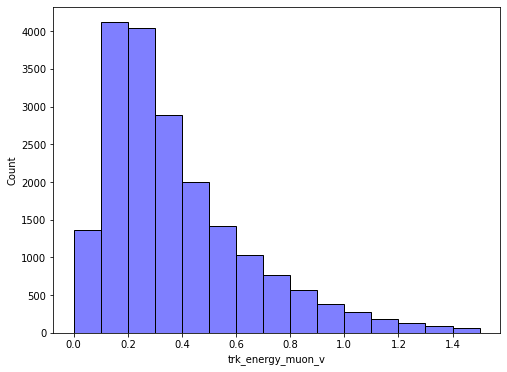

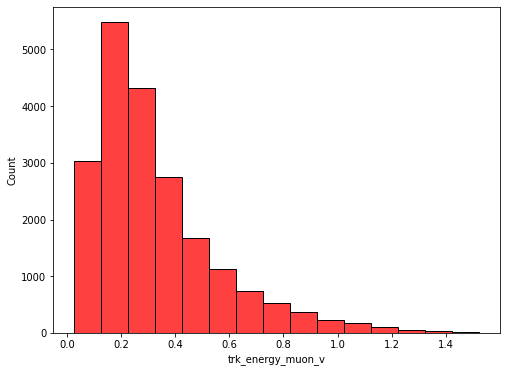

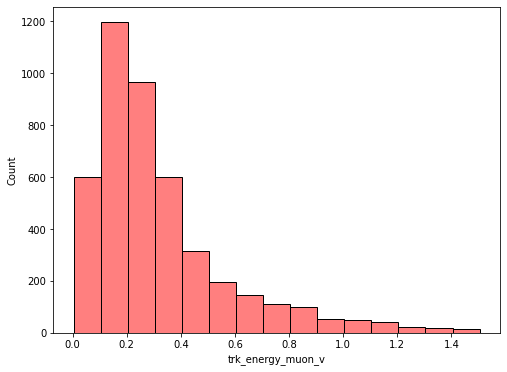

In [9]:
#this is with full run




#Get height of MC bins
MC_figure = plt.figure(figsize=(8,6))
MC = sns.histplot(data=df_data, x='trk_energy_muon_v', binwidth = 0.1, color = 'blue', alpha = 0.5, weights = 1/5.3, multiple = "layer", palette = 'deep')
MC_bars = MC.patches
heights_MC = [patch.get_height() for patch in MC_bars]
y = heights_MC[:14]
#print(heights_MC)


#Get height of bins
Real_figure = plt.figure(figsize=(8,6))
Data = sns.histplot(data=df_data_real, x='trk_energy_muon_v', color= 'red', binwidth = 0.1, multiple = 'layer', palette = "Set1")
bars = Data.patches
heights = [patch.get_height() for patch in bars]
y_real = heights[:14]
print(y_real)

#Height of bin for EXT file
EXT_figure = plt.figure(figsize=(8,6))
EXT = sns.histplot(data=df_data_EXT, x='trk_energy_muon_v', binwidth = 0.1, color = 'red', alpha = 0.5, weights = 1/2.07, palette = 'deep')
bars = EXT.patches
heights_EXT = [patch.get_height() for patch in bars]
y_EXT = heights_EXT[:14]

print(len(y_EXT))



In [12]:
#this is with subrun

#Get height of MC bins
MC_sub_figure = plt.figure(figsize=(8,6))
MC_sub = sns.histplot(data=df_data, x='trk_energy_muon', binwidth = 0.1, color = 'blue', alpha = 0.5, weights = 1/20.20, multiple = "layer", palette = 'deep')
MC_sub_bars = MC_sub.patches
heights_MC_sub = [patch.get_height() for patch in MC_sub_bars]
y_MC_sub = heights_MC_sub[:14]
print(heights_MC_sub)


#Height of bin for EXT file
EXT_sub_figure = plt.figure(figsize=(8,6))
EXT_sub = sns.histplot(data=df_data_EXT, x='trk_energy_muon', binwidth = 0.1, color = 'red', alpha = 0.5, weights = 1/3.9528, palette = 'deep')
bars = EXT_sub.patches
heights_EXT_sub = [patch.get_height() for patch in bars]
y_EXT_sub = heights_EXT_sub[:20]



#Get height of bins
Real_figure = plt.figure(figsize=(8,6))
Data_sub = sns.histplot(data=df_data_sub, x='trk_energy_muon', color= 'red', binwidth = 0.1, multiple = 'layer', palette = "Set1")
bars = Data_sub.patches
heights = [patch.get_height() for patch in bars]
y_sub = heights[:14]


ValueError: Could not interpret value `trk_energy_muon` for parameter `x`

<Figure size 576x432 with 0 Axes>

14
14


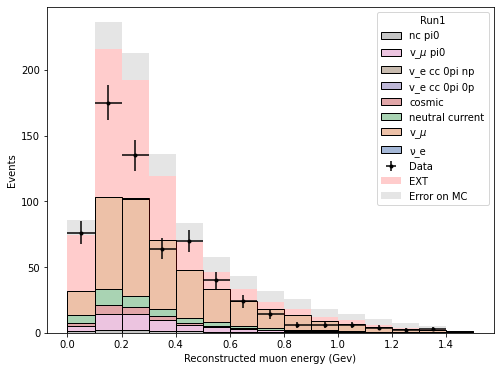

In [128]:
# Muon energy 


#energy_count  = df_data_real['trk_energy_muon_v'].value_counts()

# X values
x = np.arange(0.05, 1.45, 0.1)
# X values for EXT
x_EXT = np.arange(0.05, 1.45, 0.1)
#Y values for data points
print(len(x))

#Y error
y_error = np.sqrt(y_real)

#figure
plt.figure(figsize=(8,6))

test1 = sns.histplot(data=df_data, x='trk_energy_muon_v', hue = "category", binwidth = 0.1, color = 'blue', alpha = 0.5, weights = 1/142.1, multiple = "stack", palette = 'deep')





#MC error
MC_y_error = np.sqrt(y)
Bottom_MC = [a + b for a, b in zip(y, y_EXT)]

print(len(Bottom_MC))


#test2 = sns.histplot(data=df_data_real, x='trk_energy_muon_v', binwidth = 0.1, color = 'blue', alpha = 0.5)








#Error on data
plt.errorbar(x, y_real , yerr = y_error, xerr=0.05, fmt='.k');

#EXT added on top
plt.bar(x_EXT, y_EXT, width = 0.1, bottom = y, color='red', alpha=0.2)

#Error on MC
plt.bar(x, 2*MC_y_error, width = 0.1, bottom = Bottom_MC, color='gray', alpha=0.2)



plt.legend(title='Run1', loc='upper right', labels =['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e', 'Data', 'EXT', 'Error on MC'])

plt.xlabel("Reconstructed muon energy (Gev)")
plt.ylabel("Events")


plt.savefig('muon_energy.jpg', dpi=300)
plt.show()


In [ ]:
#sub

#figure
plt.figure(figsize=(8,6))

# y error
y_error_sub = np.sqrt(y_sub)
#MC error
MC_y_error_sub = np.sqrt(y_MC_sub)

test1 = sns.histplot(data=df_data, x='trk_energy_muon', hue = "category", binwidth = 0.1, color = 'blue', alpha = 0.5, weights = 1/20.2, multiple = "stack", palette = 'deep')

Bottom_MC_sub = [a + b for a, b in zip(y_MC_sub, y_EXT_sub)]

#Error on data
plt.errorbar(x, y_sub , yerr = y_error_sub, xerr=0.05, fmt='.k');

#EXT added on top
plt.bar(x_EXT, y_EXT_sub, width = 0.1, bottom = y_MC_sub, color='red', alpha=0.2)

#Error on MC
plt.bar(x, 2*MC_y_error_sub, width = 0.1, bottom = Bottom_MC_sub, color='gray', alpha=0.2)



plt.legend(title='Run1', loc='upper right', labels =['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e', 'Data','EXT', 'Error on MC'])

plt.xlabel("Reconstructed muon energy (Gev)")
plt.ylabel("Events")


plt.savefig('muon_energy_sub.jpg', dpi=300)
plt.show()



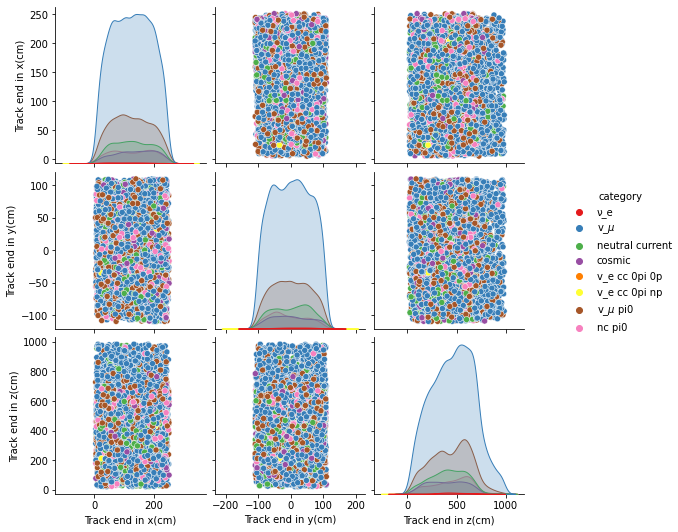

In [45]:
variables = names = ["trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v"]

new_labels=['ν_e', 'v_'r'$\mu$', 'neutral current', 'cosmic', 'v_e cc 0pi 0p', 'v_e cc 0pi np', 'v_'r'$\mu$'' pi0', 'nc pi0']

pairplots_end_points = sns.pairplot(df_data.head(10000), vars=variables, hue="category", palette='Set1')
for t, l in zip(pairplots_end_points._legend.texts, new_labels):
     t.set_text(l)
    
xlabels = ['Track end in x(cm)', 'Track end in y(cm)', 'Track end in z(cm)']
ylabels = ['Track end in x(cm)', 'Track end in y(cm)', 'Track end in z(cm)']


for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        pairplots_end_points.axes[j,i].xaxis.set_label_text(xlabels[i])
        pairplots_end_points.axes[j,i].yaxis.set_label_text(ylabels[j])
    
    
pairplots_end_points._legend.set_bbox_to_anchor((1.15, 0.5))
plt.savefig('2Dendpoints.jpg', bbox_inches='tight', dpi=300)
plt.show(pairplots_end_points)

In [48]:
pd.set_option('display.max_columns', 200)
df_data.head('')

category  crthitpe  topological_score  trk_sce_end_z_v  trk_sce_end_y_v  trk_sce_end_x_v  pfp_generation_v  trk_distance     trk_len  trk_score  trk_llr_pid_score_v  trk_sce_start_z_v  trk_sce_start_y_v  trk_sce_start_x_v     CosmicIP  hits_ratio  reco_nu_vtx_sce_x  reco_nu_vtx_sce_y  reco_nu_vtx_sce_z  n_tracks_contained  slpdg  crtveto  nslice  weightTune  pi0_dedx2_fit_Y      nu_e  nu_purity_from_pfp  true_nu_vtx_x  true_nu_vtx_y  true_nu_vtx_z  npi0  nu_pdg  npion  nproton  ccnc  pi0_dedx1_fit_Y     pi0_e  pi0_gammadot  pi0_energy1_Y  pi0_energy2_Y  pi0_radlen2  pi0_radlen1  pi0_dot1  pi0_dot2  pi0_shrscore1  pi0_shrscore2  pi0_mass_Y  selected  contained_fraction  isVtxInFiducial  pfnhits  trkshrhitdist2  weightSplineTimesTune  shr_energy_y_v  shr_energy_tot  shr_energy_v_v  shr_energy_u_v  shr_dedx_y_v  shr_dedx_v_v  shr_dedx_u_v    shr_dist_v  n_showers_contained  shr_energy_tot_cali  CosmicIPAll3D    trkfit  subcluster
entry subentry                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
25    0                2       0.0           0.306541       651.175781        21.461061        74.817955                 2      0.254957  199.004990   1.000000             0.977432         494.462769         -35.424450         181.047836  9999.000000    0.000000         181.149490         -35.626728         494.299530                   1     14        0       1    1.089636         2.157331  0.735944            0.980617     179.722839     -35.276848     494.756653     0      14      0        0     0         6.907896  0.000000     -1.000000      -1.000000      -1.000000    -1.000000    -1.000000 -1.000000 -1.000000      -1.000000      -1.000000   -1.000000         0            1.000000             True     1135       -1.000000               1.134475    5.100500e+02        0.000000    5.691933e+02    4.052457e+02  2.859258e+00  2.201264e+00  5.620037e+00  2.549572e-01                    0             0.000000    9999.000000  1.000000  2147483648
30    0               21       0.0           0.988050       412.749390       -50.978100        49.373692                 2      0.489967  186.950470   0.999766             0.974594         230.882111         -78.821793          52.340084    99.537315    0.220930          52.482918         -78.427124         230.622833                   3     14        0       1    1.000000         2.157331  1.775601            0.981294      51.326965     -78.993073     229.714203     1      14      1        0     0         6.907896  0.451288     -1.000000      -1.000000      -1.000000    -1.000000    -1.000000 -1.000000 -1.000000      -1.000000      -1.000000   -1.000000         1            1.000000             True     1307        6.287322               1.000000    4.779480e+02        0.218261    5.197834e+02    4.773931e+02  2.135675e+00  4.785339e+00  2.170383e-01  4.899665e-01                    1             0.221639      99.537315  0.210526           5
      2               21       0.0           0.988050       253.063095       -73.988472        44.263622                 2      0.489967  186.950470   0.999766             0.818806        

In [30]:
df_data.keys()

Index(['category', 'crthitpe', 'topological_score', 'trk_sce_end_z_v',
       'trk_sce_end_y_v', 'trk_sce_end_x_v', 'pfp_generation_v',
       'trk_distance', 'trk_len', 'trk_score', 'trk_llr_pid_score_v',
       'trk_sce_start_z_v', 'trk_sce_start_y_v', 'trk_sce_start_x_v',
       'CosmicIP', 'hits_ratio', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y',
       'reco_nu_vtx_sce_z', 'n_tracks_contained', 'slpdg', 'crtveto', 'nslice',
       'weightTune', 'pi0_dedx2_fit_Y', 'nu_e', 'nu_purity_from_pfp',
       'true_nu_vtx_x', 'true_nu_vtx_y', 'true_nu_vtx_z', 'npi0', 'nu_pdg',
       'npion', 'nproton', 'ccnc', 'pi0_dedx1_fit_Y', 'pi0_e', 'pi0_gammadot',
       'pi0_energy1_Y', 'pi0_energy2_Y', 'pi0_radlen2', 'pi0_radlen1',
       'pi0_dot1', 'pi0_dot2', 'pi0_shrscore1', 'pi0_shrscore2', 'pi0_mass_Y',
       'selected', 'contained_fraction', 'isVtxInFiducial', 'pfnhits',
       'trkshrhitdist2', 'weightSplineTimesTune', 'shr_energy_y_v',
       'shr_energy_tot', 'shr_energy_v_v', 'shr_energy_

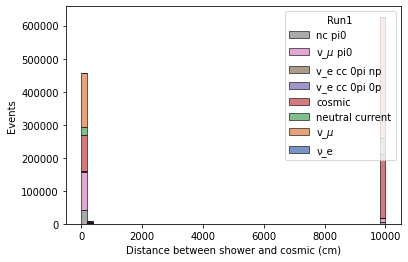

'\n\nk = sns.histplot(data=df_data, x="trk_sce_start_x_v", hue="category", legend = False, multiple="stack", palette = \'deep\')\n\nplt.legend(title=\'Run1\', loc=\'upper right\', labels=[\'nc pi0\', \'v_\'r\'$\\mu$\'\' pi0\', \'v_e cc 0pi np\', \'v_e cc 0pi 0p\', \'cosmic\', \'neutral current\', \'v_\'r\'$\\mu$\', \'ν_e\'])\nk.set(xlabel="Track start point in x (cm)", ylabel = "Events")\nplt.savefig(\'start_x0.jpg\', dpi=300)\nplt.show(k)\n\nl = sns.histplot(data=df_data, x="trk_sce_start_y_v", hue="category", legend = False, multiple="stack", palette = \'deep\')\n\nplt.legend(title=\'Run1\', loc=\'upper right\', labels=[\'nc pi0\', \'v_\'r\'$\\mu$\'\' pi0\', \'v_e cc 0pi np\', \'v_e cc 0pi 0p\', \'cosmic\', \'neutral current\', \'v_\'r\'$\\mu$\', \'ν_e\'])\nl.set(xlabel="Track start point in y (cm)", ylabel = "Events")\nplt.savefig(\'start_y0.jpg\', dpi=300)\nplt.show(l)\n\nm = sns.histplot(data=df_data, x="trk_sce_start_z_v", hue="category", legend = False, multiple="stack", palette

In [16]:

"""
hist_2D = sns.histplot(data=df_cut_muon, x="trk_sce_end_x_v", y="trk_sce_end_y_v", cbar=True)
plt.title('v_'r'$\mu$')
hist_2D.set(xlabel="End of track in x", ylabel = "End of track in y")
plt.savefig('hist_2D.jpg', bbox_inches='tight', dpi=300)
plt.show(hist_2D)


df_cut_muon = df_data.loc[df_data['category'] == 2]

hist_2D = sns.histplot(data=df_cut_muon, x="trk_sce_end_x_v", y="trk_sce_end_z_v", cbar=True)
plt.title('v_'r'$\mu$')
hist_2D.set(xlabel="End of track in x (cm)", ylabel = "End of track in z (cm)")
plt.savefig('hist_2Dxzend.jpg', bbox_inches='tight', dpi=300)
plt.show(hist_2D)


hist_2D = sns.histplot(data=df_cut_muon, x="trk_sce_end_x_v", y="trk_sce_end_y_v", cbar=True)
plt.title('v_'r'$\mu$')
hist_2D.set(xlabel="End of track in x (cm)", ylabel = "End of track in y (cm)")
plt.savefig('hist_2D.jpg', bbox_inches='tight', dpi=300)
plt.show(hist_2D)


df_cut_muon = df_data.loc[df_data['category'] == 2]

hist_2D = sns.histplot(data=df_cut_muon, x="trk_sce_end_y_v", y="trk_sce_end_z_v", cbar=True)
plt.title('v_'r'$\mu$')
hist_2D.set(xlabel="End of track in y (cm)", ylabel = "End of track in z (cm)")
plt.savefig('hist_2Dyzend.jpg', bbox_inches='tight', dpi=300)
plt.show(hist_2D)



hist_2D = sns.histplot(data=df_cut_muon, x="trk_sce_start_x_v", y="trk_sce_start_y_v", cbar=True)
plt.title('v_'r'$\mu$')
hist_2D.set(xlabel="start of track in x (cm)", ylabel = "start of track in y (cm)")
plt.savefig('hist_2Dstart.jpg', bbox_inches='tight', dpi=300)
plt.show(hist_2D)

df_cut_muon = df_data.loc[df_data['category'] == 2]

hist_2D = sns.histplot(data=df_cut_muon, x="trk_sce_start_x_v", y="trk_sce_start_z_v", cbar=True)
plt.title('v_'r'$\mu$')
hist_2D.set(xlabel="start of track in x (cm)", ylabel = "start of track in z (cm)")
plt.savefig('hist_2Dxzstart.jpg', bbox_inches='tight', dpi=300)
plt.show(hist_2D)

df_cut_muon = df_data.loc[df_data['category'] == 2]

hist_2D = sns.histplot(data=df_cut_muon, x="trk_sce_start_y_v", y="trk_sce_start_z_v", cbar=True)
plt.title('v_'r'$\mu$')
hist_2D.set(xlabel="start of track in y (cm)", ylabel = "start of track in z (cm)")
plt.savefig('hist_2Dyzstart.jpg', bbox_inches='tight', dpi=300)
plt.show(hist_2D)

hist_2D = sns.histplot(data=df_cut_muon, x="reco_nu_vtx_sce_x", y="reco_nu_vtx_sce_y", cbar=True)
plt.title('v_'r'$\mu$')
hist_2D.set(xlabel="Vertex x position (cm)", ylabel = "Vertex y position (cm)")
plt.savefig('hist_2Dvertex.jpg', bbox_inches='tight', dpi=300)
plt.show(hist_2D)

hist_2D = sns.histplot(data=df_cut_muon, x="reco_nu_vtx_sce_x", y="reco_nu_vtx_sce_z", cbar=True)
plt.title('v_'r'$\mu$')
hist_2D.set(xlabel="Vertex x position (cm)", ylabel = "Vertex z position (cm)")
plt.savefig('hist_2Dvertexxz.jpg', bbox_inches='tight', dpi=300)
plt.show(hist_2D)



hist_2D = sns.histplot(data=df_cut_muon, x="reco_nu_vtx_sce_y", y="reco_nu_vtx_sce_z", cbar=True)
plt.title('v_'r'$\mu$')
hist_2D.set(xlabel="Vertex y position (cm)", ylabel = "Vertex z position (cm)")
plt.savefig('hist_2Dvertexyz.jpg', bbox_inches='tight', dpi=300)
plt.show(hist_2D)



















trk_score0 = sns.histplot(data=df_data, x="trk_score", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
trk_score0.set(xlabel="Track Score", ylabel = "Events")
plt.savefig('trk_score0.jpg', bbox_inches='tight', dpi=300)
plt.show(trk_score0)

s = sns.histplot(data=df_data, x="trk_sce_end_x_v", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
s.set(xlabel="Track end point in x (cm)", ylabel = "Events")
plt.savefig('end_x0.jpg', dpi=300)
plt.show(s)

t = sns.histplot(data=df_data, x="trk_sce_end_y_v", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
t.set(xlabel="Track end point in y (cm)", ylabel = "Events")
plt.savefig('end_y0.jpg', dpi=300)
plt.show(t)

u = sns.histplot(data=df_data, x="trk_sce_end_z_v", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
u.set(xlabel="Track end point in z (cm)", ylabel = "Events")
plt.savefig('end_z0.jpg', dpi=300)
plt.show(u)

r= sns.histplot(data=df_data, x="pfp_generation_v", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
r.set(xlabel="Generation: neutrino-1, daughter-2, further-3", ylabel = "Events")
plt.savefig('pfp_generation_v0.jpg', bbox_inches='tight', dpi=300)
plt.show(r)


a = sns.histplot(data=df_data, x="nslice", hue="category", multiple="stack", palette = 'deep')
plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
a.set(xlabel="neutrino slice variable", ylabel = "Events")
plt.savefig('nslice0.jpg',bbox_inches='tight', dpi=300)
plt.show(a)

b = sns.histplot(data=df_data, x="crtveto", hue="category", legend = False, multiple="stack",  palette = 'deep')
plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
b.set(xlabel="boolean for CRT veto", ylabel = "Events")
plt.savefig('CRT0.jpg', bbox_inches='tight', dpi=300)
plt.show(b)

c = sns.histplot(data=df_data, x="slpdg", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
c.set(xlabel="PDG code from pandora 12-shower-like 14-track-like", ylabel = "Events")
plt.savefig('pdg0.jpg', dpi=300)
plt.show(c)

d = sns.histplot(data=df_data, x="n_tracks_contained", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1change', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
d.set(xlabel="tracks contained in fiducial volume", ylabel = "Events")
plt.savefig('tracks_contained0.jpg', dpi=300)
plt.show(d)

e = sns.histplot(data=df_data, x="reco_nu_vtx_sce_y", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
e.set(xlabel="Vertex position in y (cm)", ylabel = "Events")
plt.savefig('VTX_y0.jpg', dpi=300)
plt.show(e)

f = sns.histplot(data=df_data, x="reco_nu_vtx_sce_z", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
f.set(xlabel="Vertex position in z (cm)", ylabel = "Events")
plt.savefig('VTX_z0.jpg', dpi=300)
plt.show(f)

g = sns.histplot(data=df_data, x="hits_ratio", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
g.set(xlabel="Ratio between hits from showers and hits in slice", ylabel = "Events")
plt.savefig('hits_ratio0.jpg', dpi=300)
plt.show(g)


i = sns.histplot(data=df_data, x="reco_nu_vtx_sce_x", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
i.set(xlabel="Vertex position in x (cm)", ylabel = "Events")
plt.savefig('vertex_x0.jpg', dpi=300)
plt.show(i)

"""
j = sns.histplot(data=df_data, x="CosmicIP", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
j.set(xlabel="Distance between shower and cosmic (cm)", ylabel = "Events")
plt.savefig('Cosmic0.jpg', bbox_inches='tight', dpi=300)
plt.show(j)

"""

k = sns.histplot(data=df_data, x="trk_sce_start_x_v", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
k.set(xlabel="Track start point in x (cm)", ylabel = "Events")
plt.savefig('start_x0.jpg', dpi=300)
plt.show(k)

l = sns.histplot(data=df_data, x="trk_sce_start_y_v", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
l.set(xlabel="Track start point in y (cm)", ylabel = "Events")
plt.savefig('start_y0.jpg', dpi=300)
plt.show(l)

m = sns.histplot(data=df_data, x="trk_sce_start_z_v", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
m.set(xlabel="Track start point in z (cm)", ylabel = "Events")
plt.savefig('start_z0.jpg', dpi=300)
plt.show(m)


n = sns.histplot(data=df_data, x="trk_llr_pid_score_v", hue="category", legend = False, multiple="stack", palette = 'deep')

plt.legend(title='Run1', loc='upper right', labels=['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e'])
n.set(xlabel="Log likelihood ratio PID score", ylabel = "Events")
plt.savefig('likelihood0.jpg', dpi=300)
plt.show(n)

"""




